Imports y configs
=================

In [6]:
# imports de libs que usamos para leer y procesar datos en masa
import os

import numpy as np
import pandas as pd
from PIL import Image

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning: separar conjuntos de datos, evaluar exactitud, etc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# libs que usamos para construir y entrenar redes neuronales
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout, Convolution2D, MaxPooling2D, Flatten

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [7]:
# algunas configuraciones generales respecto a las imagenes
picture_size = 64

# nombres de las columnas de datos que vamos a usar como "entradas"
input_columns = ['c%i' % i for i in range(picture_size ** 2)]

In [8]:
def get_picture_data(picture):
    picture = picture.resize((picture_size, picture_size), Image.ANTIALIAS).convert('L')
    picture_data = np.array(list(picture.getdata())).reshape(len(input_columns))
    
    return picture_data

def get_pictures_data(pictures): 
    raw_pictures_data = list(map(get_picture_data, pictures))
    pictures_data = pd.DataFrame(raw_pictures_data, columns=input_columns)

    return pictures_data

def load_pictures(pictures_path):
    for subitem in sorted(os.listdir(pictures_path)):
        subitem_path = os.path.join(pictures_path, subitem)
        
        if os.path.isdir(subitem_path):
            print('reading from', subitem, '...')
        
            for picture_name in os.listdir(subitem_path):
                picture_path = os.path.join(subitem_path, picture_name)
                yield Image.open(picture_path)
        else:
            yield Image.open(subitem_path)

In [9]:
print('loading falcon pictures...')
falcons = get_pictures_data(load_pictures('./data/falcon/'))
print('loading lambda pictures...')
lambdas = get_pictures_data(load_pictures('./data/lambda/'))

falcons['label'] = 1
lambdas['label'] = 0

print('merging both datasets (this also de-references the original datasets to save memory)...')
data = pd.concat([falcons, lambdas])
del falcons
del lambdas

print('data shape:', data.shape)
data.head()

loading falcon pictures...
loading lambda pictures...
merging both datasets (this also de-references the original datasets to save memory)...
data shape: (2504, 4097)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c4087,c4088,c4089,c4090,c4091,c4092,c4093,c4094,c4095,label
0,99,99,98,98,104,105,106,107,106,108,...,133,134,136,138,140,141,141,142,142,1
1,111,111,111,111,113,116,119,119,122,120,...,135,134,136,137,135,137,142,146,147,1
2,106,108,110,108,106,108,111,110,109,111,...,117,120,119,122,122,122,122,125,125,1
3,86,91,107,115,113,113,116,118,118,119,...,119,119,119,122,120,120,122,124,126,1
4,85,83,92,101,109,117,115,114,118,117,...,116,117,118,118,118,118,116,118,122,1


In [10]:
def show_images(samples, title=None):
    for index, sample in samples.iterrows():
        if title is not None:
            plt.title(str(sample[title]))

        sample_as_grid = sample[input_columns].values.reshape(picture_size, picture_size)
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest', cmap='Greys_r')

        plt.show()

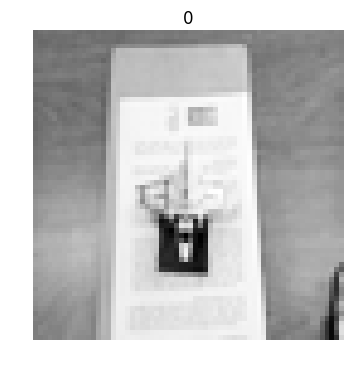

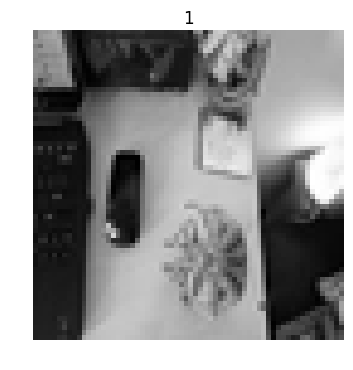

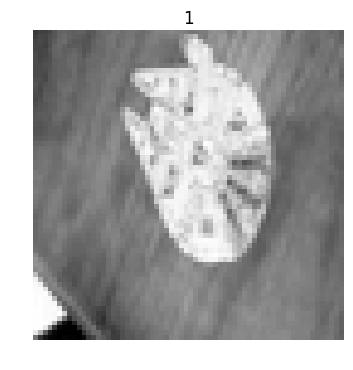

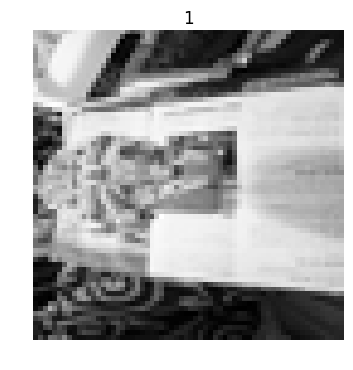

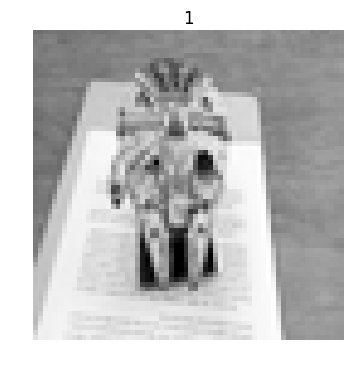

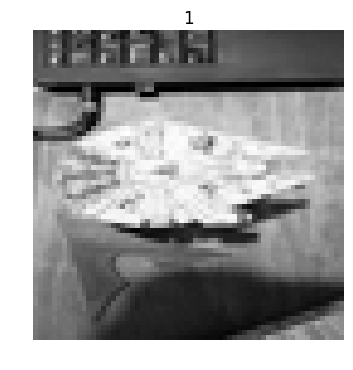

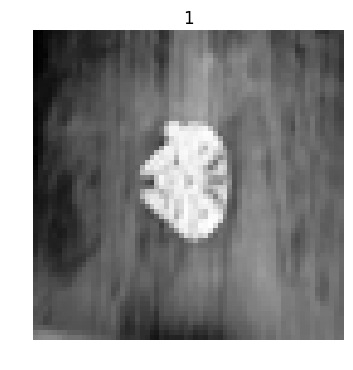

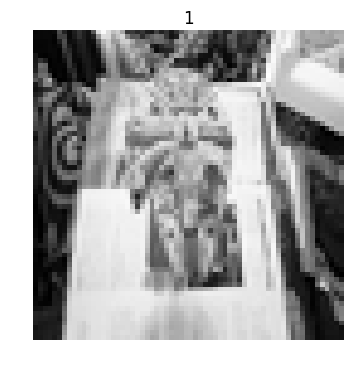

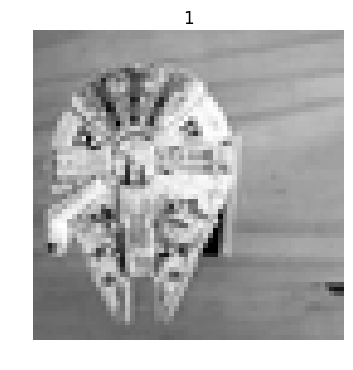

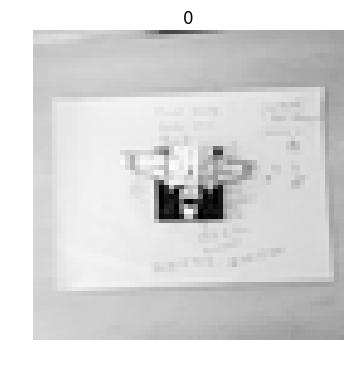

In [11]:
show_images(data.sample(10), title='label')

In [13]:
train, test = train_test_split(data, test_size=0.2)
sets = (
    ('train', train),
    ('test', test),
)

for set_name, set_data in sets:
    print('#' * 20, set_name, 'labels', '#' * 20)
    print(set_data.label.value_counts())
    print()

#################### train labels ####################
0    1029
1     974
Name: label, dtype: int64

#################### test labels ####################
1    256
0    245
Name: label, dtype: int64



In [15]:
def extract_inputs(dataset):
    return dataset[input_columns].values.reshape(len(dataset), picture_size, picture_size, 1) / 255

In [16]:
model = Sequential([        
    Convolution2D(16, 4, 4, border_mode='valid', input_shape=(picture_size, picture_size, 1)),
    Activation('tanh'),
    Convolution2D(16, 4, 4),
    Activation('tanh'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.1),
    Flatten(),

    Dense(200),
    Activation('tanh'),
    Dropout(0.1),
    Dense(200),
    Activation('tanh'),
    Dropout(0.1),

    Dense(1),
    Activation('sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [19]:
model.fit(
    extract_inputs(train), 
    train.label.values, 
    nb_epoch=2,
    batch_size=128,
)

Epoch 1/2
2003/2003 [==============================] - 1s - loss: 0.0313 - acc: 0.9900     
Epoch 2/2
2003/2003 [==============================] - 1s - loss: 0.0187 - acc: 0.9940     


In [20]:
for set_name, set_data in sets:
    labels = set_data.label.values
    predicted_labels = np.rint(model.predict(extract_inputs(set_data)))

    print('#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(labels, predicted_labels))
    print(classification_report(labels, predicted_labels))
    

######################### train #########################
accuracy 0.999500748877
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1029
          1       1.00      1.00      1.00       974

avg / total       1.00      1.00      1.00      2003

######################### test #########################
accuracy 0.99001996008
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       245
          1       0.99      0.99      0.99       256

avg / total       0.99      0.99      0.99       501



In [21]:
test_with_predictions = test.copy()
test_with_predictions['prediction'] = model.predict(extract_inputs(test_with_predictions))
test_with_predictions['predicted_label'] = np.rint(test_with_predictions.prediction)
is_correct = test_with_predictions.label == test_with_predictions.predicted_label

Bien clasificados:

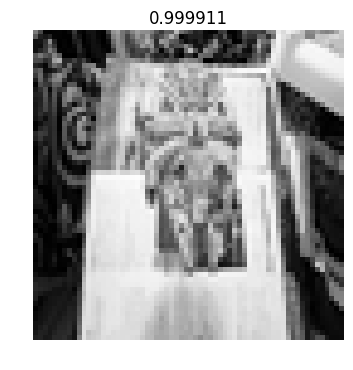

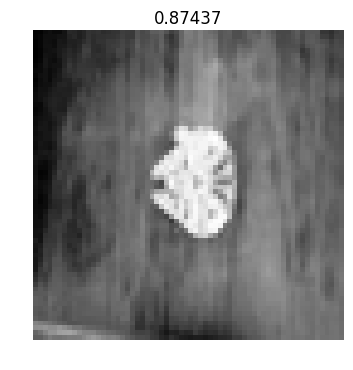

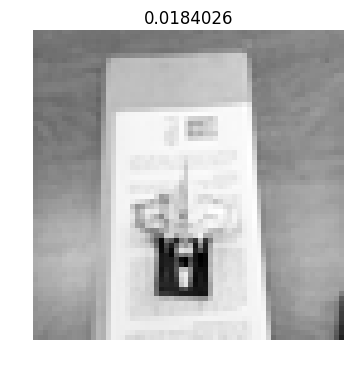

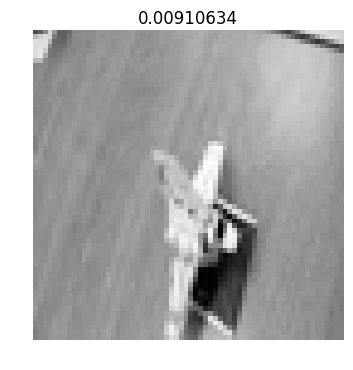

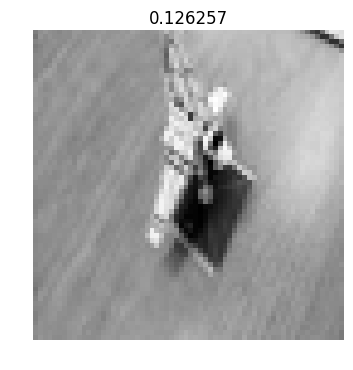

In [22]:
show_images(test_with_predictions[is_correct].sample(5), title='prediction')

Mal clasificados:

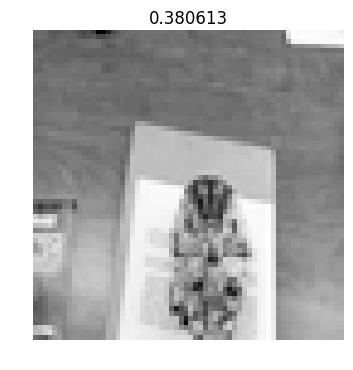

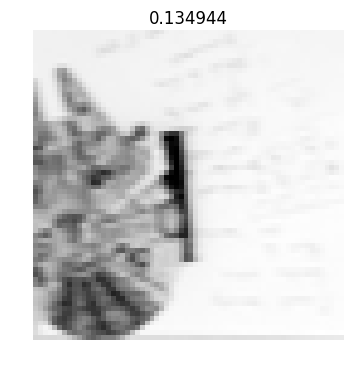

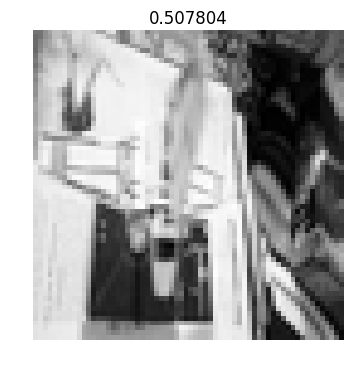

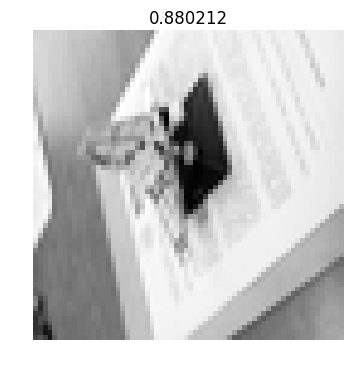

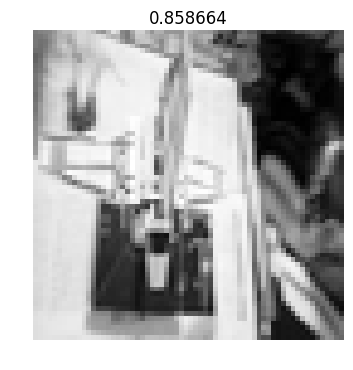

In [23]:
show_images(test_with_predictions[~is_correct].sample(5), title='prediction')

In [25]:
def classify_pictures(pictures_path):
    pictures_data = get_pictures_data(load_pictures(pictures_path))

    pictures_data['prediction'] = model.predict(extract_inputs(pictures_data))
    
    show_images(pictures_data, title='prediction')

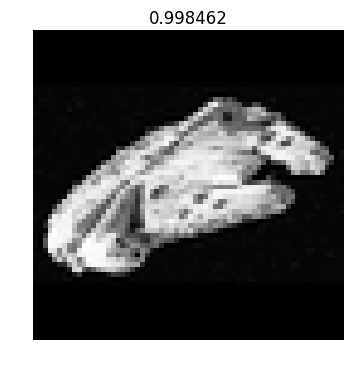

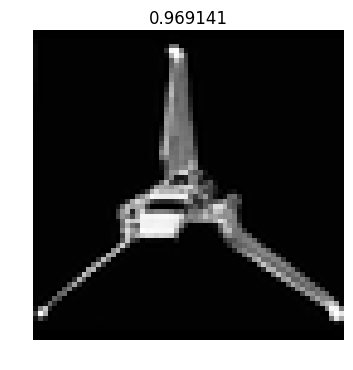

In [26]:
classify_pictures('./data/internet/')